In [2]:
!pip install tsfel
!pip install pandas
!pip install numpy
!pip install sci-kit learn
!pip install matplotlib
!pip install tsfel
import pandas as pd
import numpy as np
import tsfel
from itertools import product
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt

ERROR: Could not find a version that satisfies the requirement sci-kit (from versions: none)
ERROR: No matching distribution found for sci-kit


In [3]:
X_train = np.array(np.load("../X_train.npy"))
X_test = np.array(np.load("../X_test.npy"))
Y_train = np.array(np.load("../Y_train.npy"))
Y_test = np.array(np.load("../Y_test.npy"))
cfg = tsfel.get_features_by_domain()


In [4]:
def decision_tree_training(dataframeX,dataframeY,depth = None,random_state= 2):
    clf = tree.DecisionTreeClassifier(max_depth = depth,random_state=random_state)
    clf = clf.fit(dataframeX, dataframeY)
    return clf
def bias_variance_plotter(accuracy_dataframe):
    plt.figure(figsize=(10, 6))
    
    plt.plot(accuracy_dataframe['Depth'], accuracy_dataframe['Train Accuracy'], 
             marker='o', label='Train Accuracy', color='blue')
    
    plt.plot(accuracy_dataframe['Depth'], accuracy_dataframe['Test Accuracy'], 
             marker='o', label='Test Accuracy', color='orange')
    
    plt.title('Accuracy vs. Depth')
    plt.xlabel('Depth')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

def metrics(y_pred, y_test, labels=None, cond = False):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted',zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    labels = [1,2,3,4,5,6]
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    if cond == True:
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Precision: {precision:.4f}")
        print("\nConfusion Matrix:\n")
        print(cm_df)

    return accuracy
   


def decision_Tree_predict(clf,test_data_x):
    y_pred = clf.predict(test_data_x)
    y_pred = np.array(y_pred)
    return y_pred


def decision_Tree_plot(clf,y_pred,y_test,features):
    
    plt.figure(figsize=(20, 10))
    tree.plot_tree(clf, filled=True, feature_names=features)
    plt.title('Decision Tree Visualization')
    plt.show()
    acc = metrics(y_pred,y_test,cond=True)
    return acc

def selected_featurizer(dataframeX):
        correlation_matrix = dataframeX.corr()
        threshold = 0.98
        removals = []

        pairs = product(range(len(correlation_matrix.columns)), repeat=2)

        for i, j in pairs:
            if i > j:
                correlation_value = correlation_matrix.iloc[i, j]
                if abs(correlation_value) > threshold and correlation_value != 1:
                    colname_i = correlation_matrix.columns[i]
                    colname_j = correlation_matrix.columns[j]
                    if colname_i not in removals and colname_j not in removals:
                        removals.append(colname_i)

        selected_features = [col for col in dataframeX.columns if col not in removals]

        return selected_features

In [5]:
def decision_tree_raw(depth):
    X_test = np.array(np.load('../X_test.npy'))
    X_train = np.array(np.load('../X_train.npy'))
    y_test = np.array(np.load('../y_test.npy'))
    y_train = np.array(np.load('../y_train.npy'))
    accx = []
    accy =[]
    accz = []
    output = []
    
    for i in range(len(X_train)):
        for j in X_train[i]:
            accx.append(j[0])
            accy.append(j[1])
            accz.append(j[2])
            output.append(y_train[i])
    
    flattened_X_train = []

    for sample in X_train:
        for item in sample:
            flattened_X_train.append(item)

    flattened_X_test = []

    for sample in X_test:
        for item in sample:
            flattened_X_test.append(item)

    Xtrain_dataframe = pd.DataFrame(flattened_X_train, columns=['accx', 'accy', 'accz'])
    Xtest_dataframe = pd.DataFrame(flattened_X_test, columns=['accx', 'accy', 'accz'])
    ytrainout = pd.Series(np.repeat(y_train, 500))
    clf = decision_tree_training(Xtrain_dataframe,ytrainout,depth)

    y_pred = decision_Tree_predict(clf,Xtest_dataframe)
    y_pred = np.array(y_pred)  
    num_rows = int(len(y_pred)/500)
    y_pred_reshaped = y_pred.reshape(num_rows, 500)
    modes = []
    for row in y_pred_reshaped:
        mode = pd.Series(row).mode()
        modes.append(mode.iloc[0])
    aggr_y_pred = np.array(modes)
    acc_test = decision_Tree_plot(clf,aggr_y_pred,y_test,['Acceleration X','Acceleration Y','Acceleration Z'])


    y_pred2 = decision_Tree_predict(clf,Xtrain_dataframe)
    num_rows2 = int(len(y_pred2)/500)
    y_pred_reshaped2 = y_pred2.reshape(num_rows2, 500)
    modes2 = []
    for row in y_pred_reshaped2:
        mode2 = pd.Series(row).mode()
        modes2.append(mode2.iloc[0])
    aggr_y_pred2 = np.array(modes2)
    acc_train = metrics(aggr_y_pred2,y_train)

    return acc_test,acc_train




In [13]:
def decision_tree_TSFEL(feature_df,feature_df_test,depth = None):
    selected_features = selected_featurizer(feature_df)
    feature_df_filtered = feature_df[selected_features]
    feature_df_test_filtered = feature_df_test[selected_features]
    clf =decision_tree_training(feature_df_filtered,Y_train,depth)
    y_pred = decision_Tree_predict(clf,feature_df_test_filtered)
    acc_test = decision_Tree_plot(clf,y_pred,Y_test,feature_df_test_filtered.columns) 

    y_pred2 = decision_Tree_predict(clf,feature_df_filtered)
    acc_train = metrics(y_pred2,Y_train)

    return acc_test,acc_train
    

In [7]:
def decision_tree_features(depth = None):
    feature_labels = pd.read_csv(r'../HAR/UCI HAR Dataset/features.txt',sep = '\\s+',header=None)
    dataframeX = pd.read_csv(r'../HAR/UCI HAR Dataset/train/X_train.txt',sep = '\\s+',header=None)
    dataframeY = pd.read_csv(r'../HAR/UCI HAR Dataset/train/y_train.txt',sep = '\\s+',header=None)
    test_values_y = pd.read_csv(r'../HAR/UCI HAR Dataset/test/y_test.txt',sep = "\\s+",header=None)
    test_data_X = pd.read_csv(r'../HAR/UCI HAR Dataset/test/X_test.txt',sep = "\\s+",header=None)
    
    # selected_features = selected_featurizer(dataframeX)
    selected_features = dataframeX.columns
    filtered_dfX = dataframeX[selected_features]
    features = []
    for i in selected_features:
        features.append(feature_labels[1][i])

    
    clf = decision_tree_training(filtered_dfX,dataframeY,depth)
    
    filtered_testx =test_data_X[selected_features]
    y_test = test_values_y[0].to_numpy()
    y_pred = decision_Tree_predict(clf,filtered_testx)
    acc_test = decision_Tree_plot(clf,y_pred,y_test,features) 

    y_pred2 = decision_Tree_predict(clf,filtered_dfX)
    acc_train = metrics(y_pred2,dataframeY)

    return acc_test,acc_train

Tree of Depth : 2


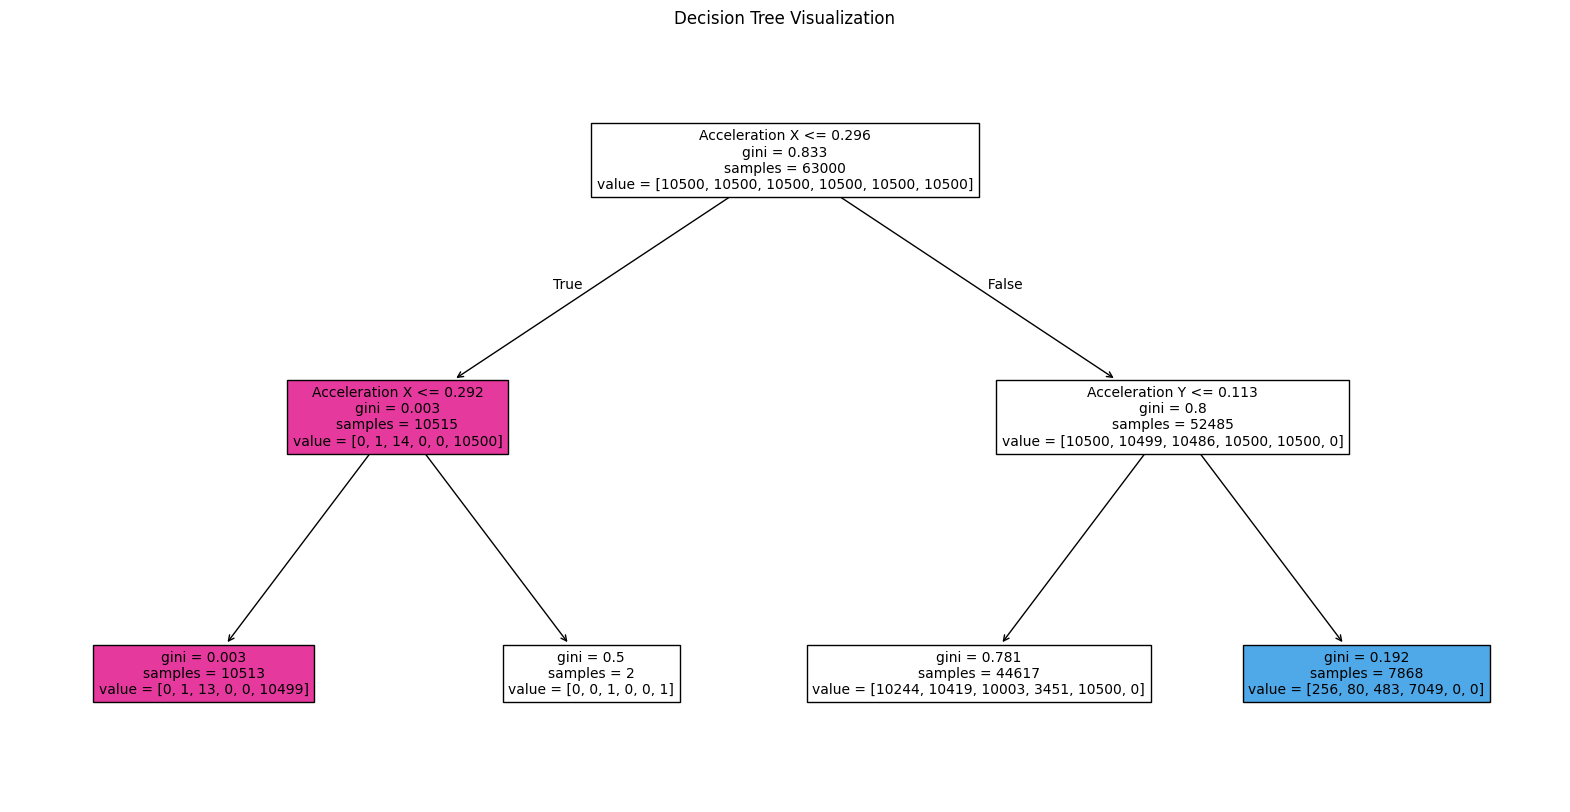

Accuracy: 0.4815
Recall: 0.4815
Precision: 0.8739

Confusion Matrix:

   1  2  3  4  5  6
1  0  0  0  0  9  0
2  0  0  0  0  9  0
3  0  0  0  0  9  0
4  0  0  0  8  1  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9
Tree of Depth : 3


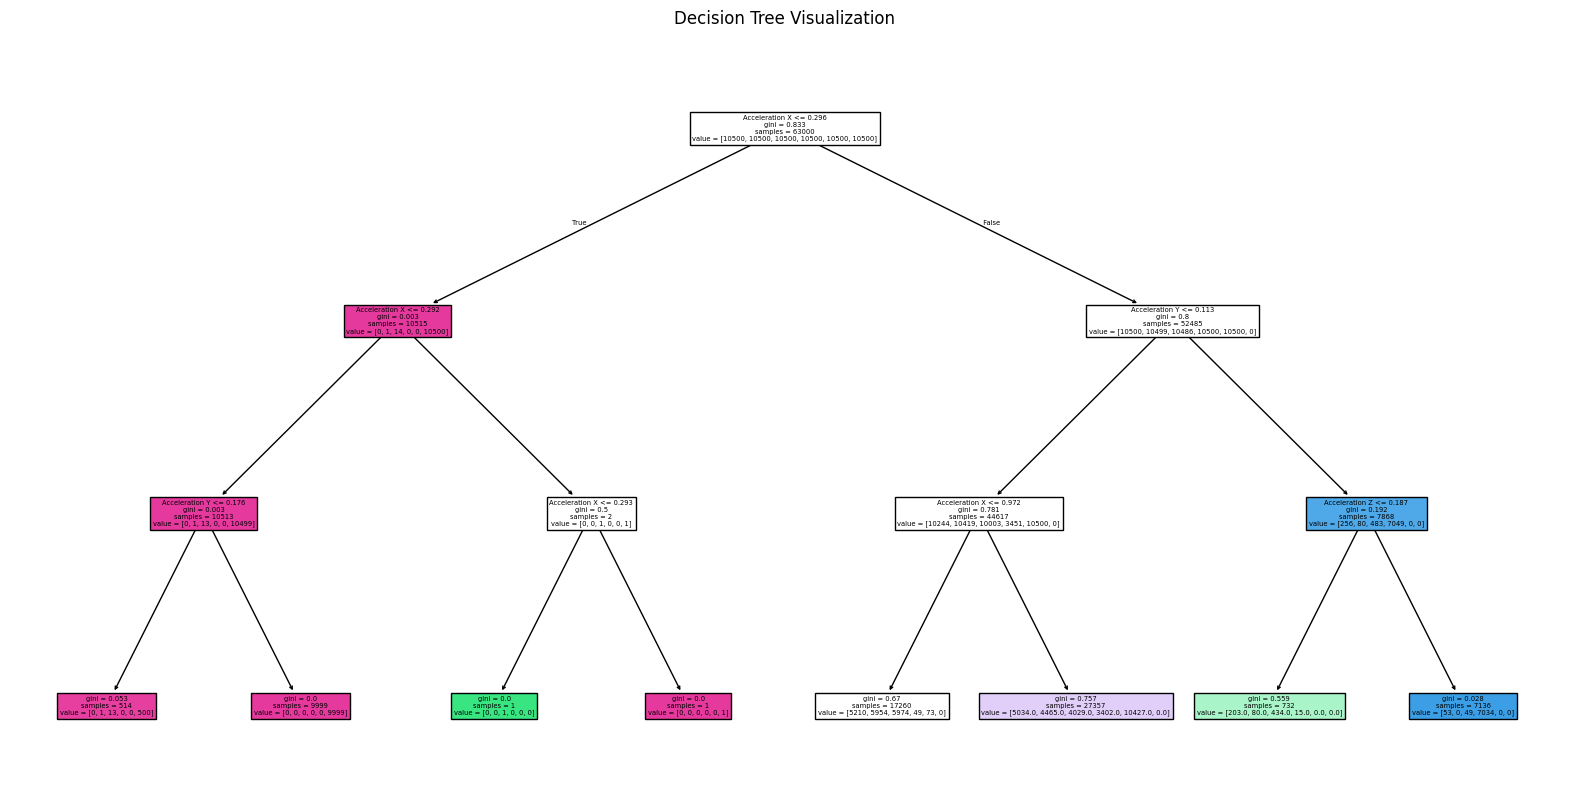

Accuracy: 0.6296
Recall: 0.6296
Precision: 0.8263

Confusion Matrix:

   1  2  3  4  5  6
1  0  0  4  0  5  0
2  0  0  7  0  2  0
3  0  0  9  0  0  0
4  0  0  1  7  1  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9
Tree of Depth : 4


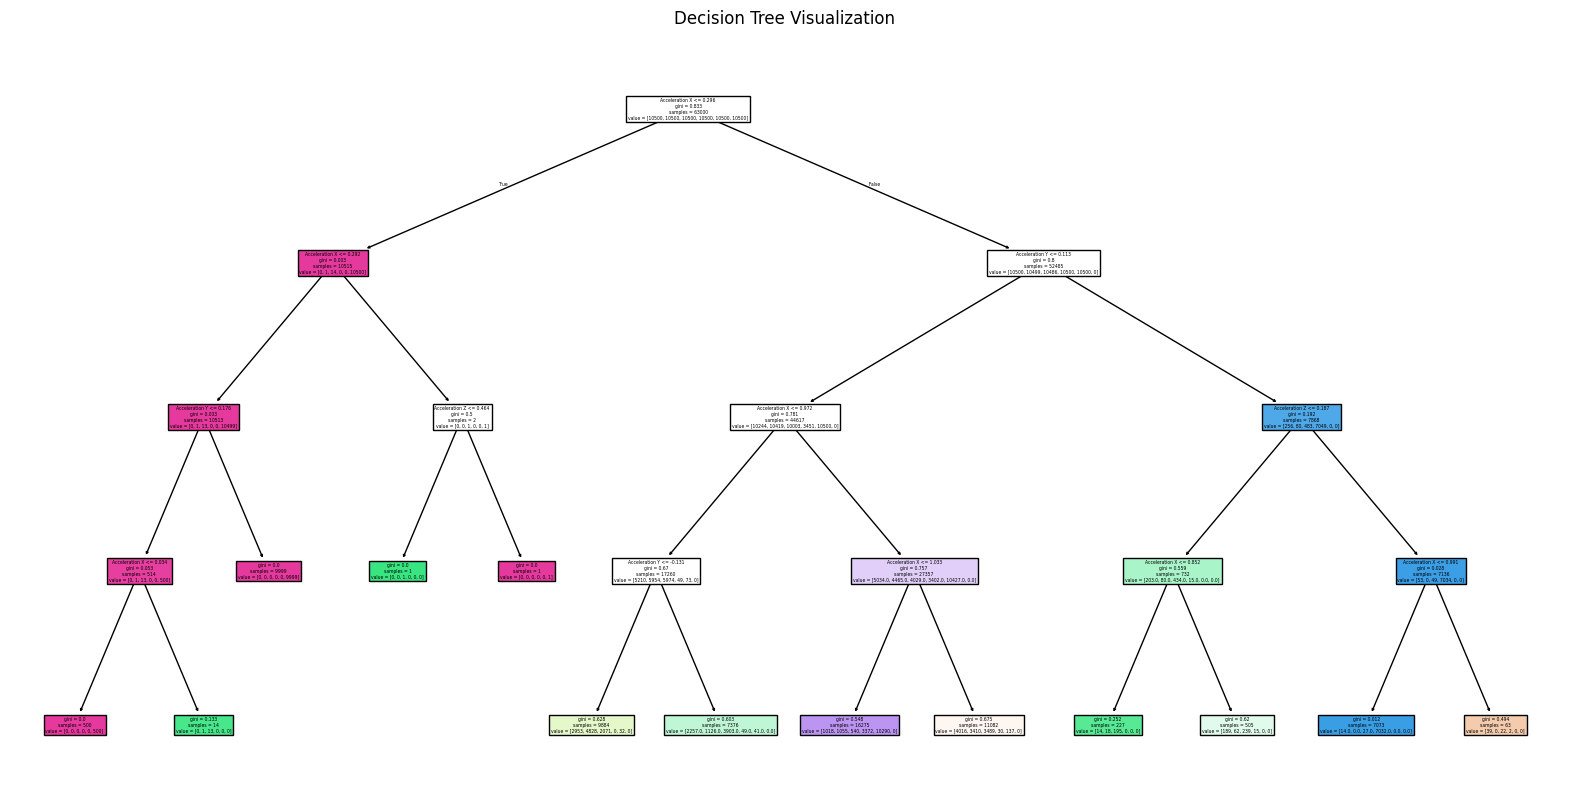

Accuracy: 0.8148
Recall: 0.8148
Precision: 0.8306

Confusion Matrix:

   1  2  3  4  5  6
1  7  1  1  0  0  0
2  3  6  0  0  0  0
3  2  1  6  0  0  0
4  0  0  1  7  1  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9
Tree of Depth : 5


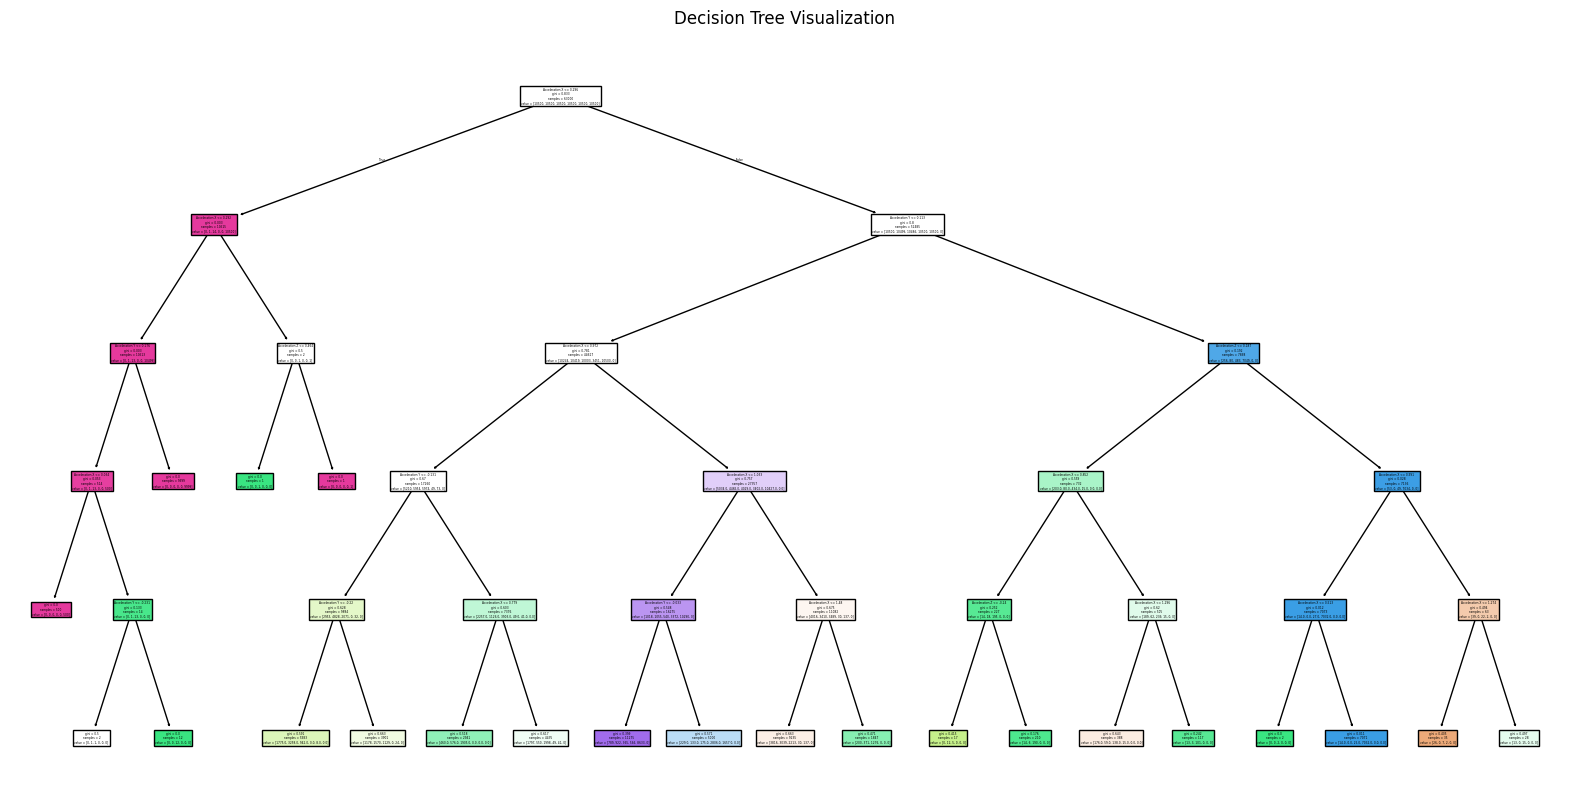

Accuracy: 0.9074
Recall: 0.9074
Precision: 0.9175

Confusion Matrix:

   1  2  3  4  5  6
1  8  1  0  0  0  0
2  2  7  0  0  0  0
3  0  1  8  0  0  0
4  1  0  0  8  0  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9
Tree of Depth : 6


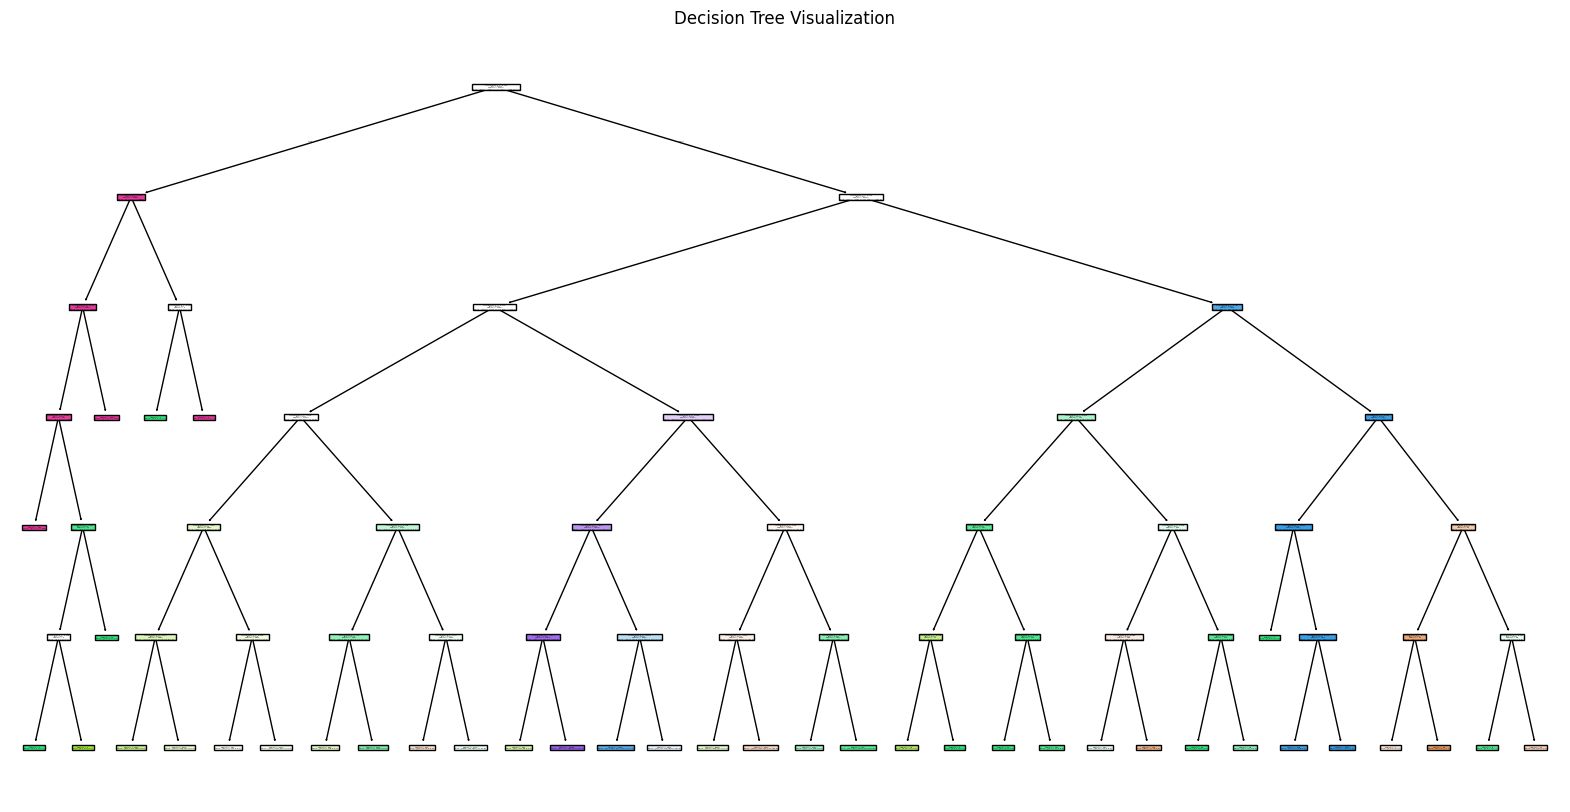

Accuracy: 0.7963
Recall: 0.7963
Precision: 0.8373

Confusion Matrix:

   1  2  3  4  5  6
1  2  6  1  0  0  0
2  0  9  0  0  0  0
3  0  3  6  0  0  0
4  1  0  0  8  0  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9
Tree of Depth : 7


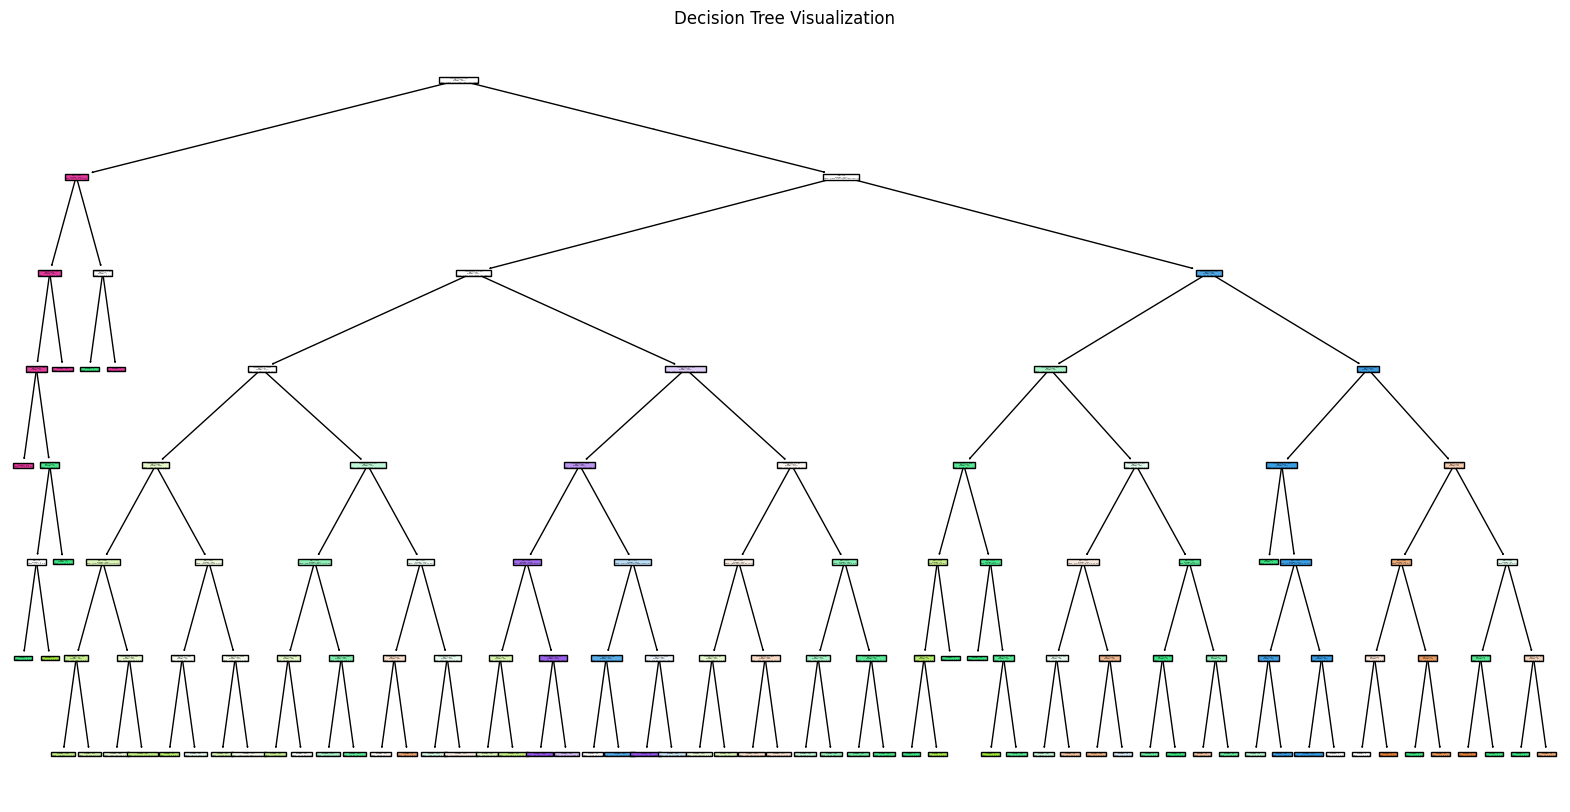

Accuracy: 0.7778
Recall: 0.7778
Precision: 0.8407

Confusion Matrix:

   1  2  3  4  5  6
1  3  6  0  0  0  0
2  1  8  0  0  0  0
3  0  4  5  0  0  0
4  1  0  0  8  0  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9
Tree of Depth : 8


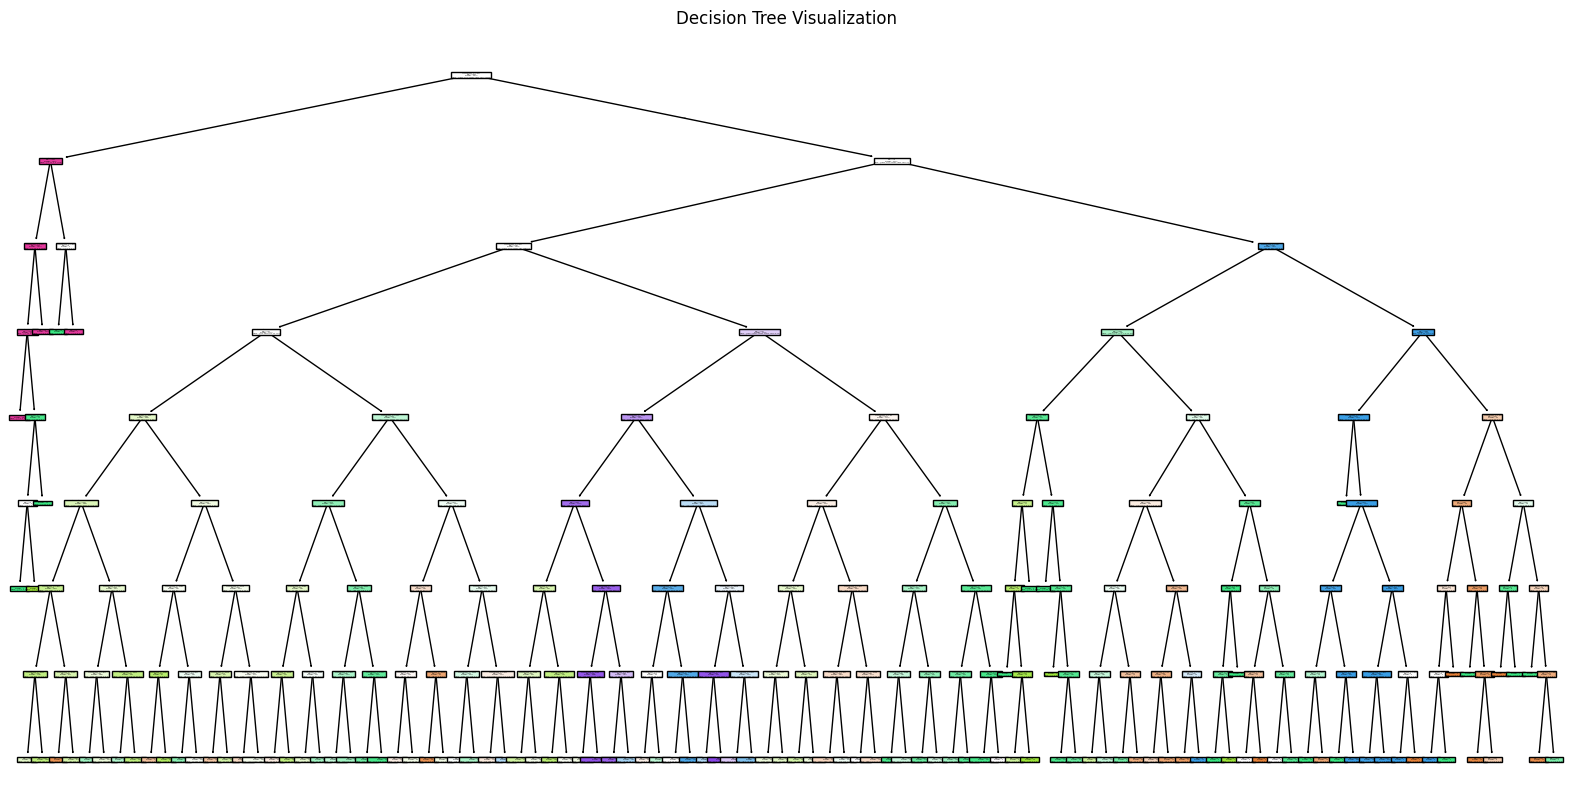

Accuracy: 0.7593
Recall: 0.7593
Precision: 0.8074

Confusion Matrix:

   1  2  3  4  5  6
1  2  6  1  0  0  0
2  1  8  0  0  0  0
3  0  4  5  0  0  0
4  0  0  0  8  1  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9


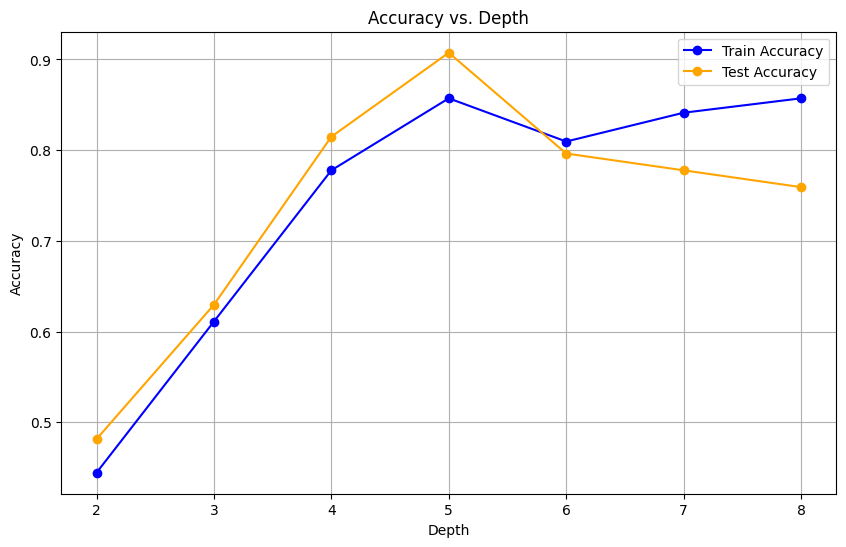

In [8]:
acc_test =[]
acc_train = []
depth = []
for i in range(2,9):
    print("Tree of Depth :",i)
    acc_test_point,acc_train_point = decision_tree_raw(depth = i)
    acc_test.append(acc_test_point)
    depth.append(i)
    acc_train.append(acc_train_point)

accuracy_dataframe = pd.DataFrame({"Depth":depth,"Train Accuracy":acc_train,"Test Accuracy":acc_test})

bias_variance_plotter(accuracy_dataframe)


In [15]:
feature_df = tsfel.time_series_features_extractor(cfg, X_train, verbose = 0, fs = 50)
feature_df_test = tsfel.time_series_features_extractor(cfg, X_test, verbose = 0, fs = 50)

Tree of Depth : 2


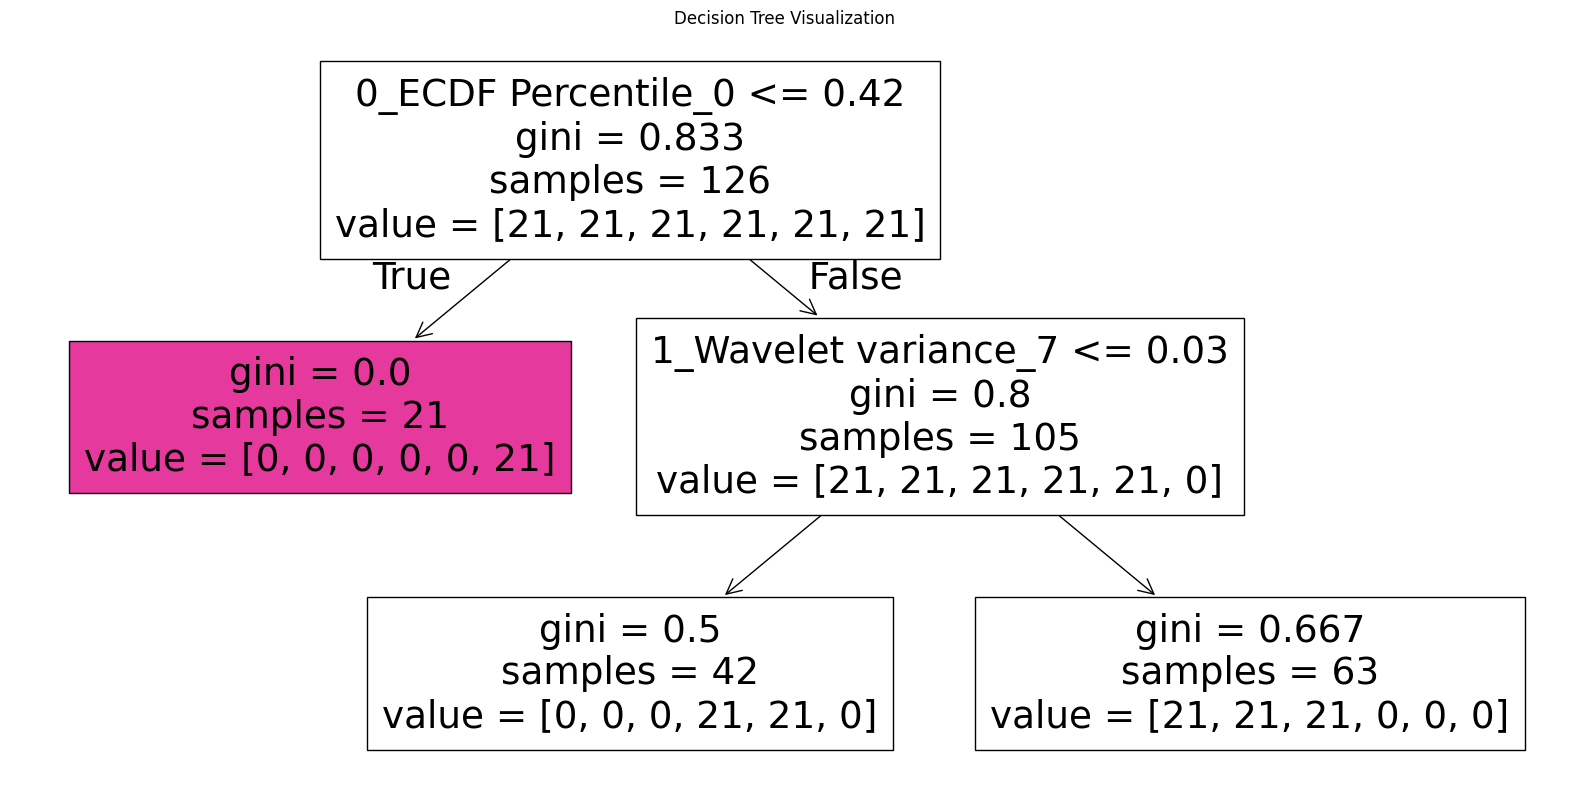

Accuracy: 0.5000
Recall: 0.5000
Precision: 0.8056

Confusion Matrix:

   1  2  3  4  5  6
1  9  0  0  0  0  0
2  9  0  0  0  0  0
3  9  0  0  0  0  0
4  0  0  0  9  0  0
5  0  0  0  9  0  0
6  0  0  0  0  0  9
Tree of Depth : 3


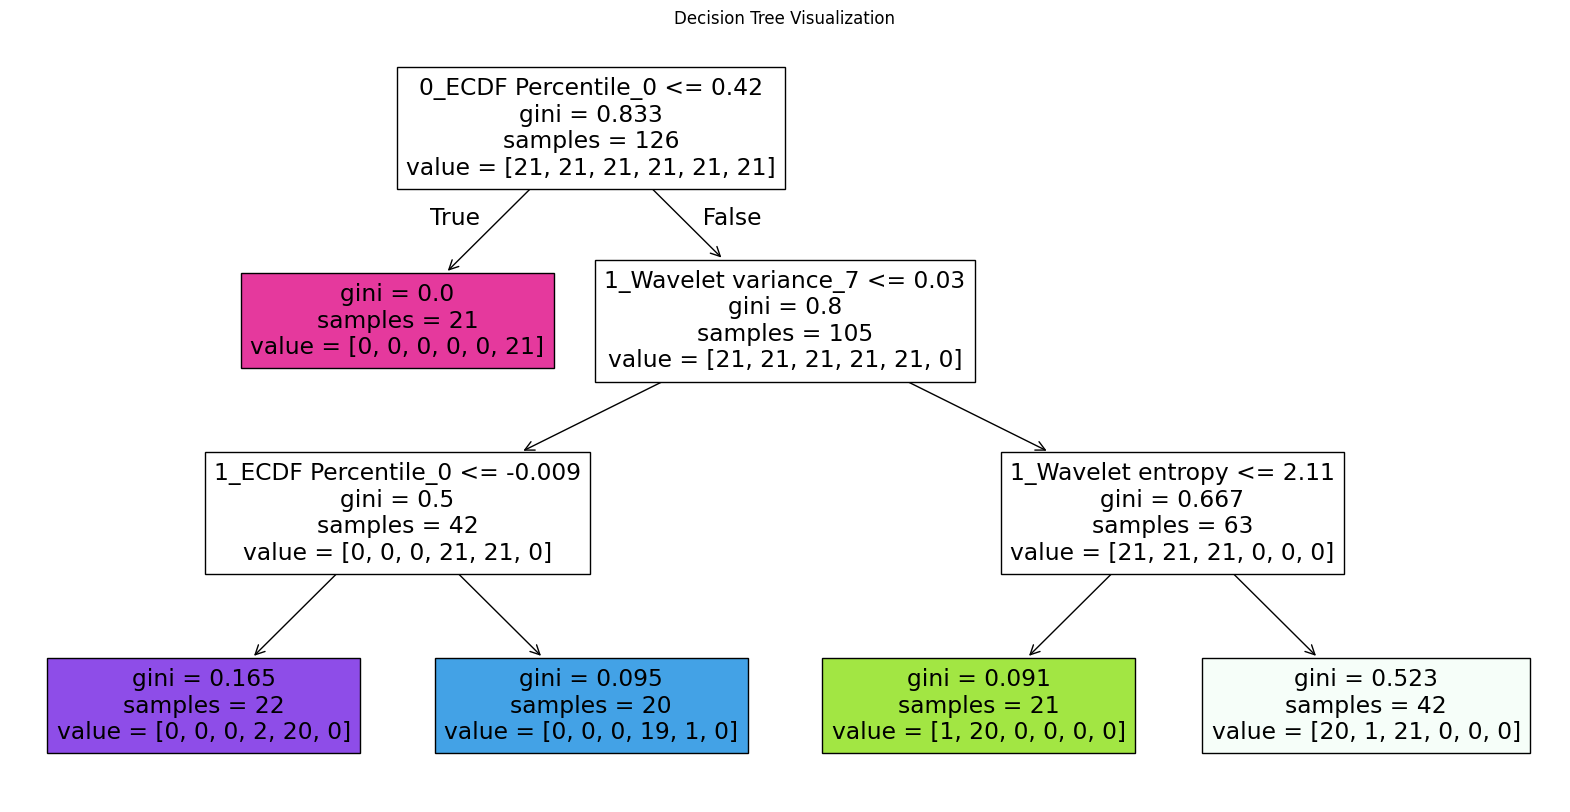

Accuracy: 0.7778
Recall: 0.7778
Precision: 0.8487

Confusion Matrix:

   1  2  3  4  5  6
1  0  2  7  0  0  0
2  0  9  0  0  0  0
3  0  2  7  0  0  0
4  0  0  0  8  1  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9
Tree of Depth : 4


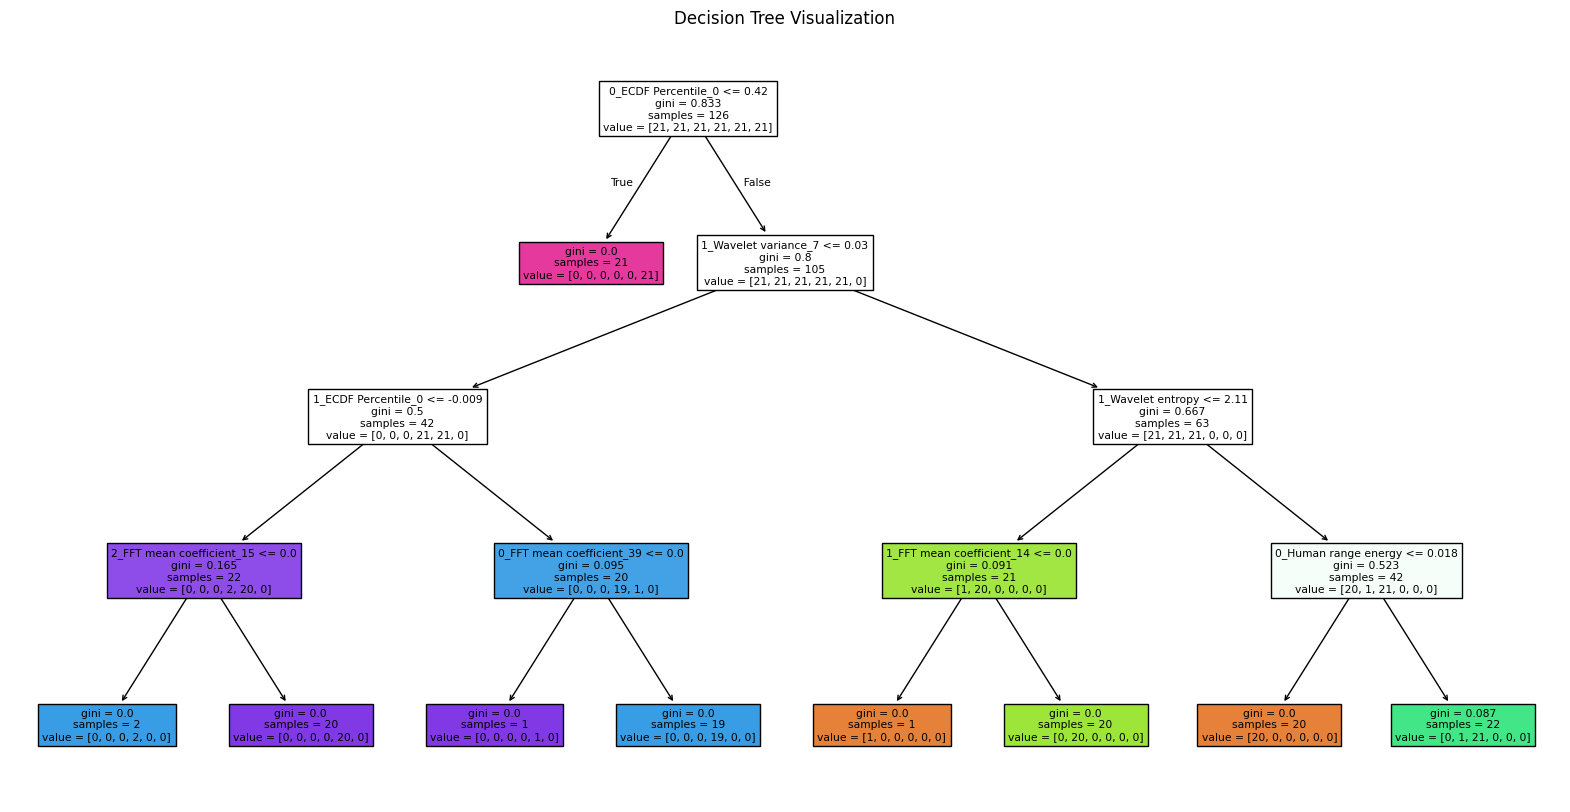

Accuracy: 0.8704
Recall: 0.8704
Precision: 0.8826

Confusion Matrix:

   1  2  3  4  5  6
1  7  1  1  0  0  0
2  1  8  0  0  0  0
3  0  2  7  0  0  0
4  0  0  0  7  2  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9
Tree of Depth : 5


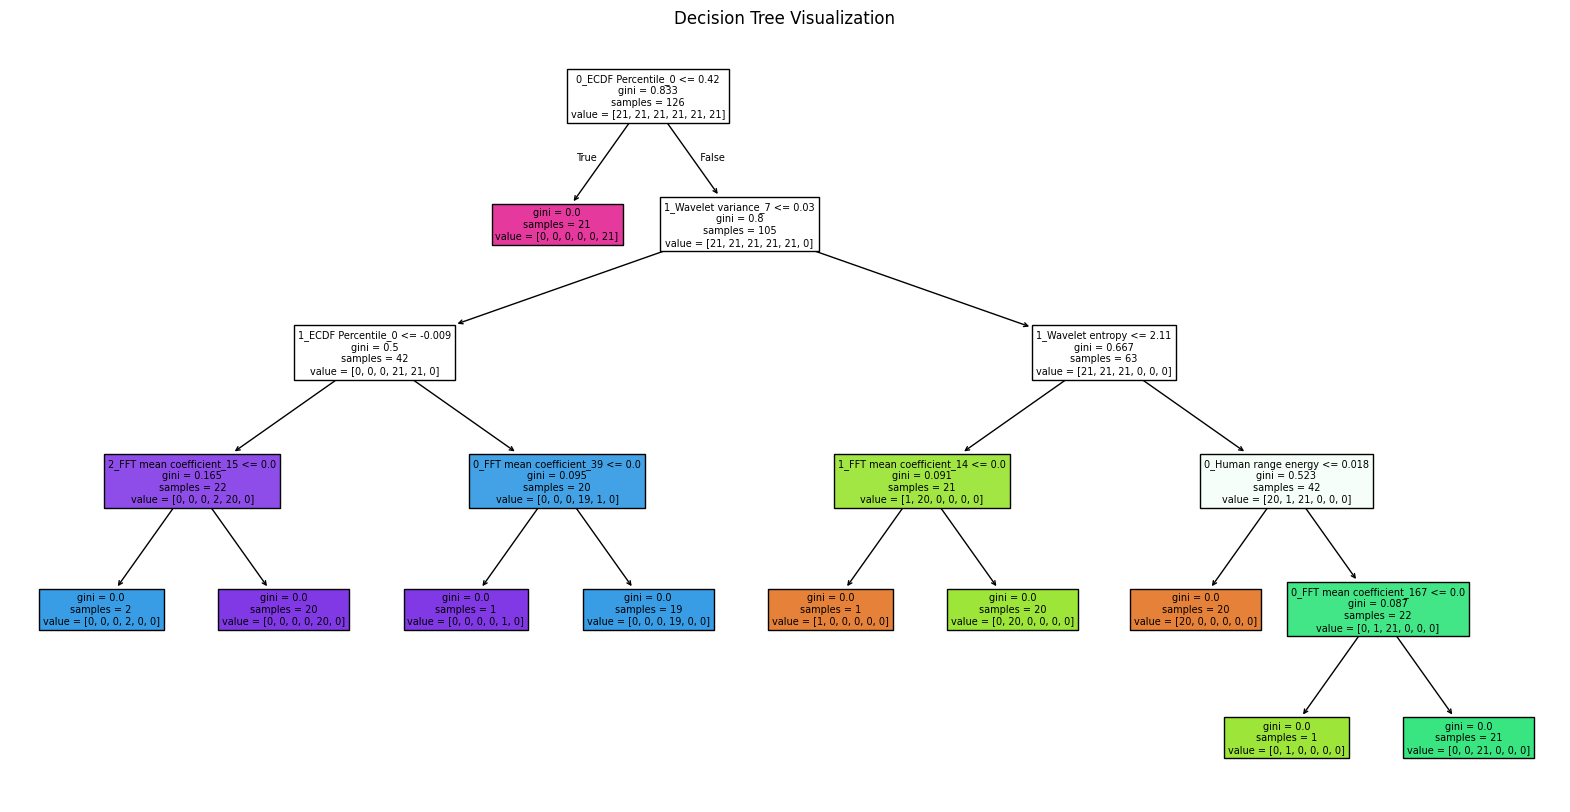

Accuracy: 0.8148
Recall: 0.8148
Precision: 0.8441

Confusion Matrix:

   1  2  3  4  5  6
1  7  1  1  0  0  0
2  1  8  0  0  0  0
3  0  5  4  0  0  0
4  0  0  0  7  2  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9
Tree of Depth : 6


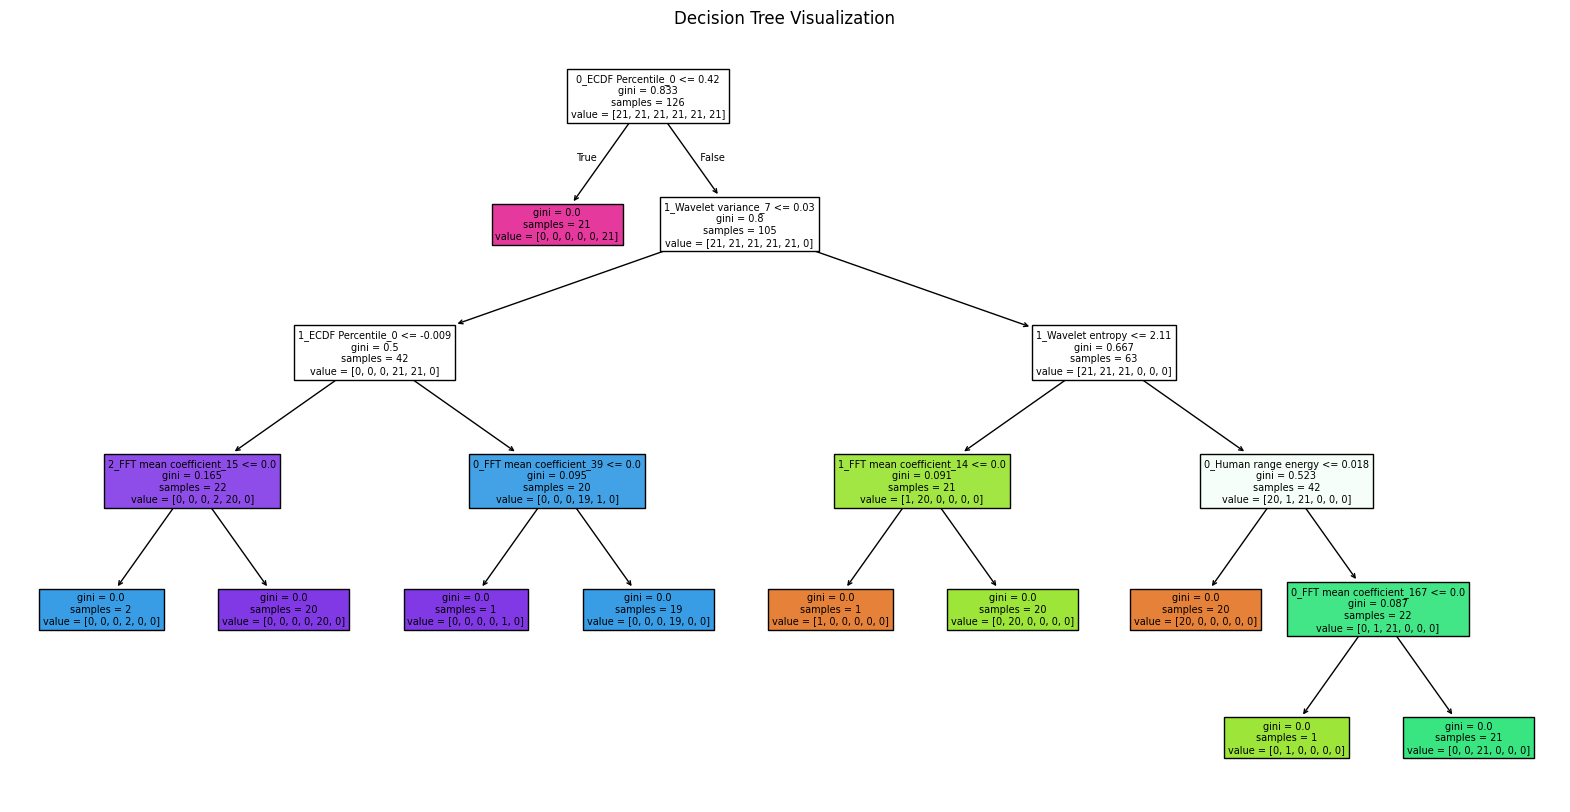

Accuracy: 0.8148
Recall: 0.8148
Precision: 0.8441

Confusion Matrix:

   1  2  3  4  5  6
1  7  1  1  0  0  0
2  1  8  0  0  0  0
3  0  5  4  0  0  0
4  0  0  0  7  2  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9
Tree of Depth : 7


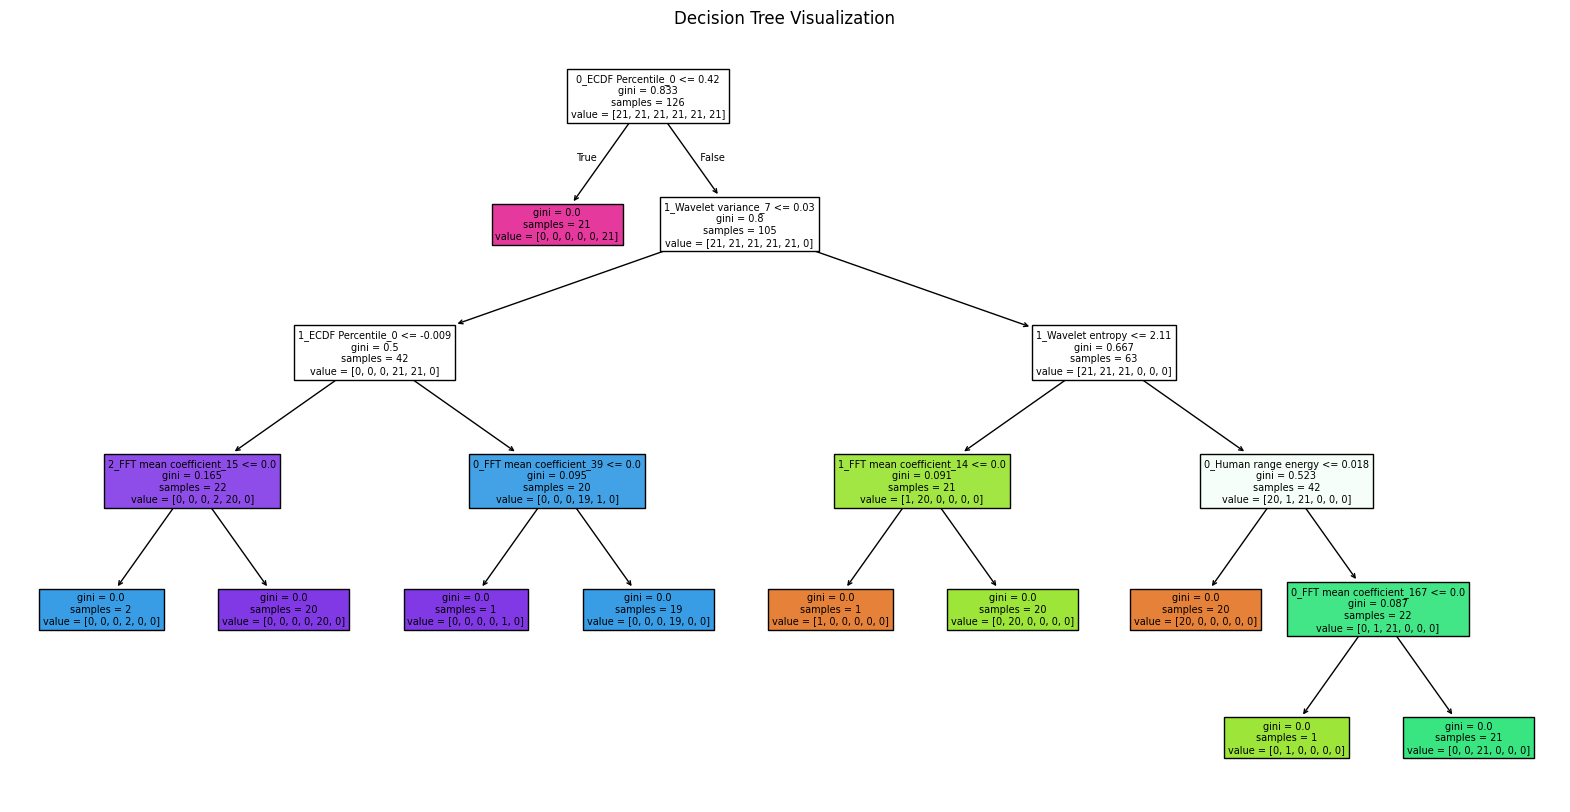

Accuracy: 0.8148
Recall: 0.8148
Precision: 0.8441

Confusion Matrix:

   1  2  3  4  5  6
1  7  1  1  0  0  0
2  1  8  0  0  0  0
3  0  5  4  0  0  0
4  0  0  0  7  2  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9
Tree of Depth : 8


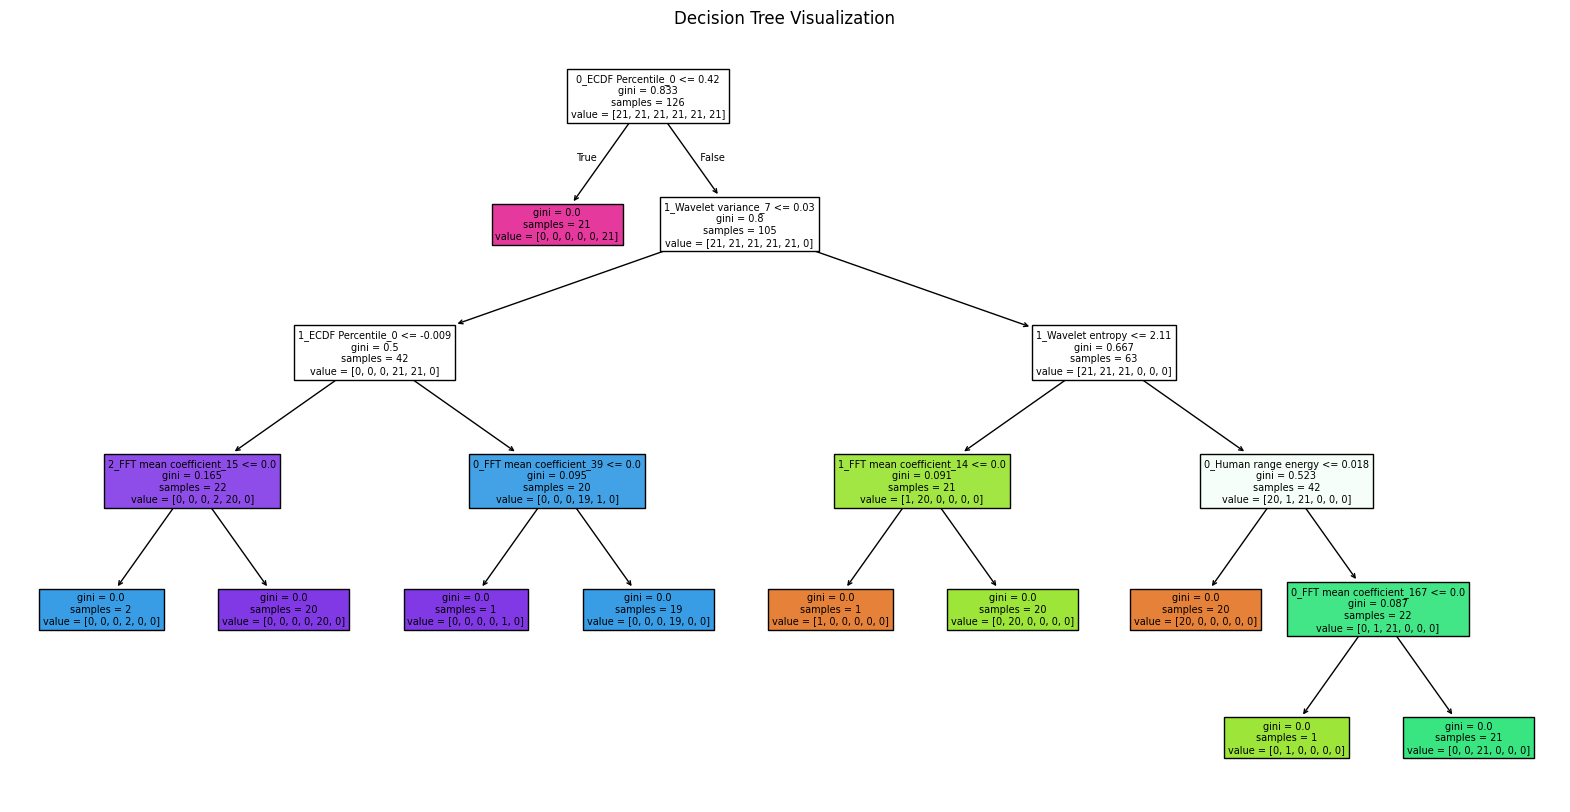

Accuracy: 0.8148
Recall: 0.8148
Precision: 0.8441

Confusion Matrix:

   1  2  3  4  5  6
1  7  1  1  0  0  0
2  1  8  0  0  0  0
3  0  5  4  0  0  0
4  0  0  0  7  2  0
5  0  0  0  0  9  0
6  0  0  0  0  0  9


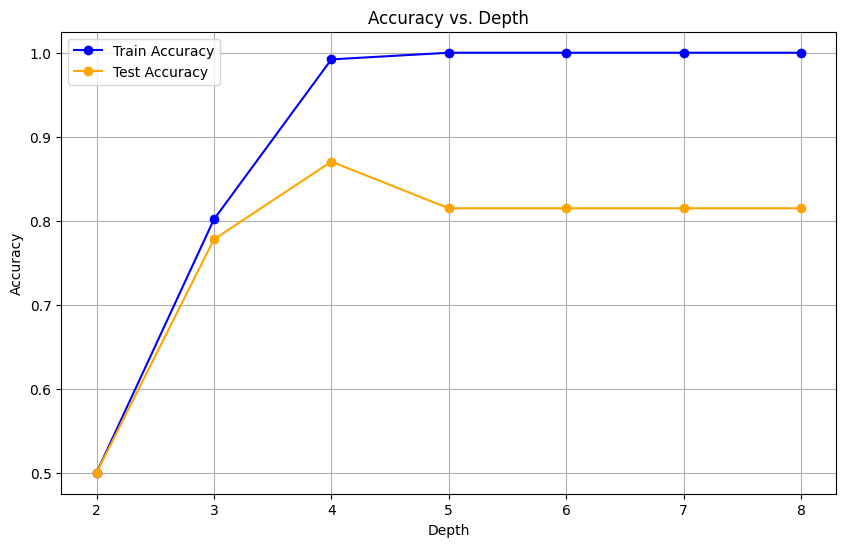

In [16]:
acc_test =[]
acc_train = []
depth = []
for i in range(2,14):
    print("Tree of Depth :",i)
    acc_test_point,acc_train_point = decision_tree_TSFEL(feature_df,feature_df_test,depth = i)
    acc_test.append(acc_test_point)
    depth.append(i)
    acc_train.append(acc_train_point)

accuracy_dataframe = pd.DataFrame({"Depth":depth,"Train Accuracy":acc_train,"Test Accuracy":acc_test})

bias_variance_plotter(accuracy_dataframe)

Tree of Depth : 2


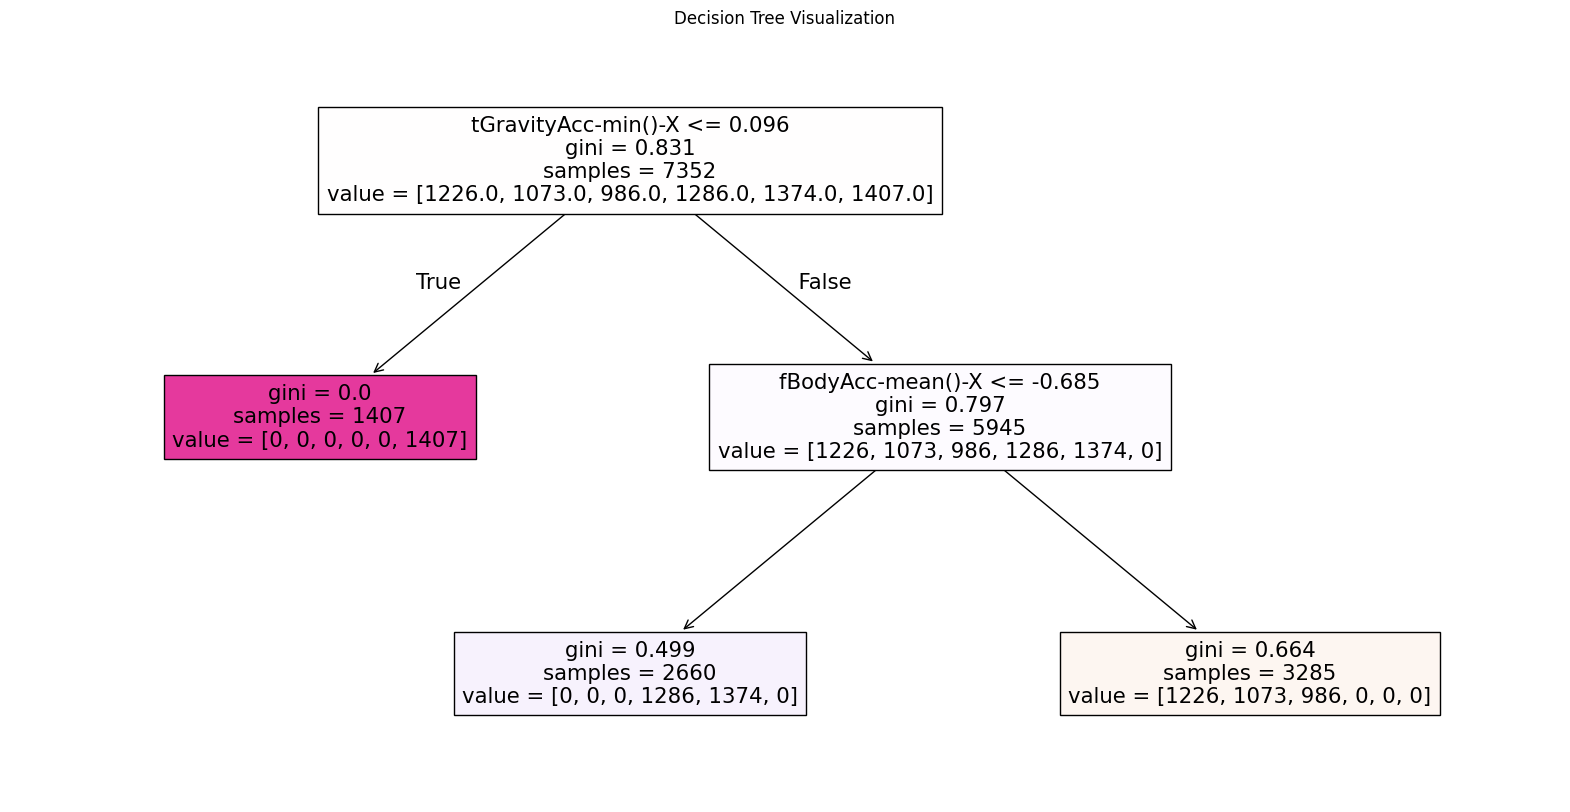

Accuracy: 0.5310
Recall: 0.5310
Precision: 0.8052

Confusion Matrix:

     1  2  3  4    5    6
1  496  0  0  0    0    0
2  471  0  0  0    0    0
3  420  0  0  0    0    0
4    0  0  0  0  491    0
5    0  0  0  0  532    0
6    0  0  0  0    0  537


Tree of Depth : 3


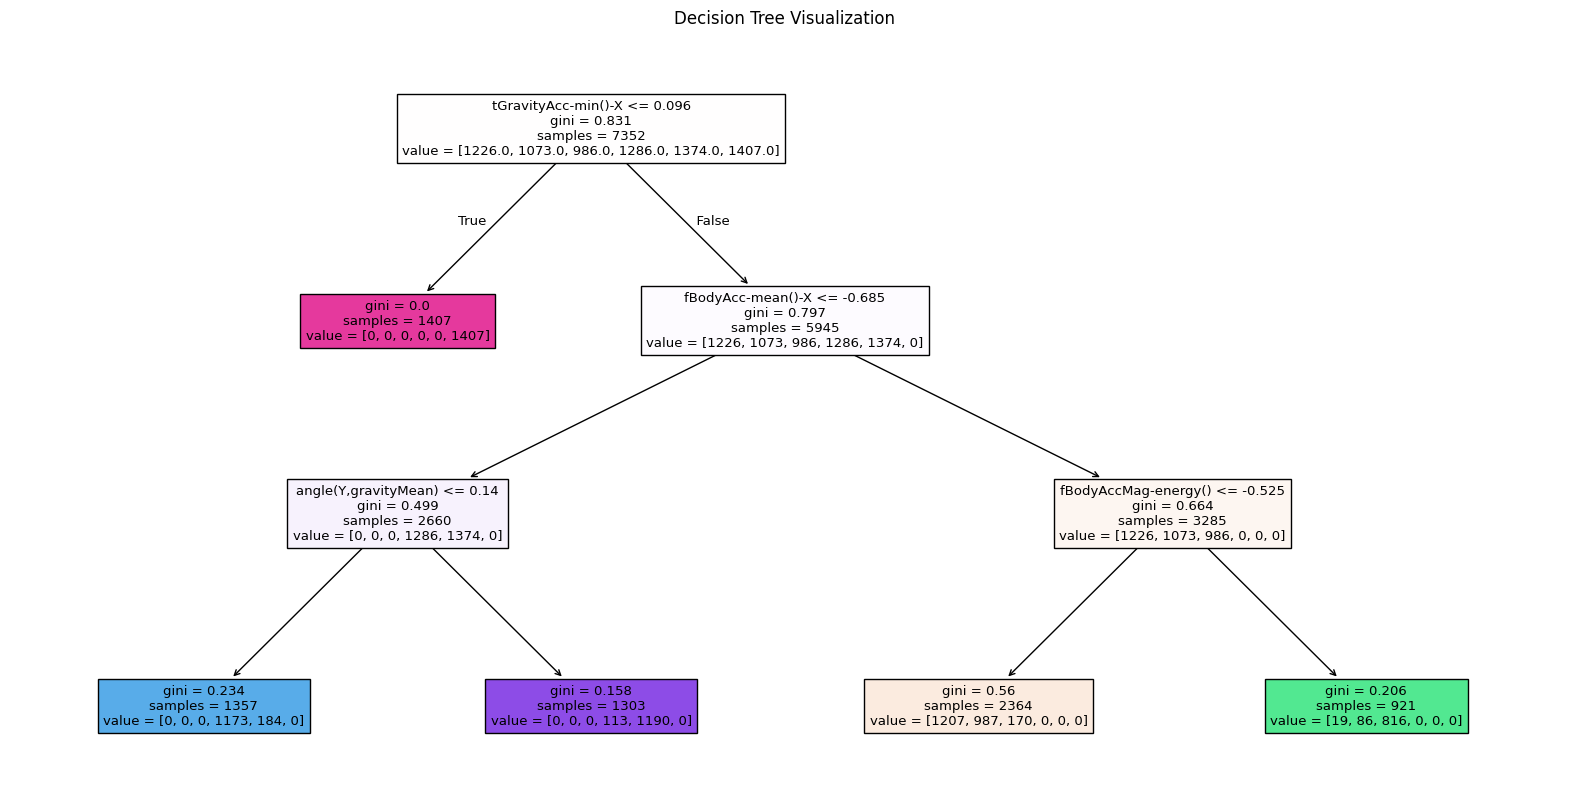

Accuracy: 0.7224
Recall: 0.7224
Precision: 0.8309

Confusion Matrix:

     1  2    3    4    5    6
1  485  0   11    0    0    0
2  463  0    8    0    0    0
3  138  0  282    0    0    0
4    0  0    0  400   91    0
5    0  0    0  107  425    0
6    0  0    0    0    0  537


Tree of Depth : 4


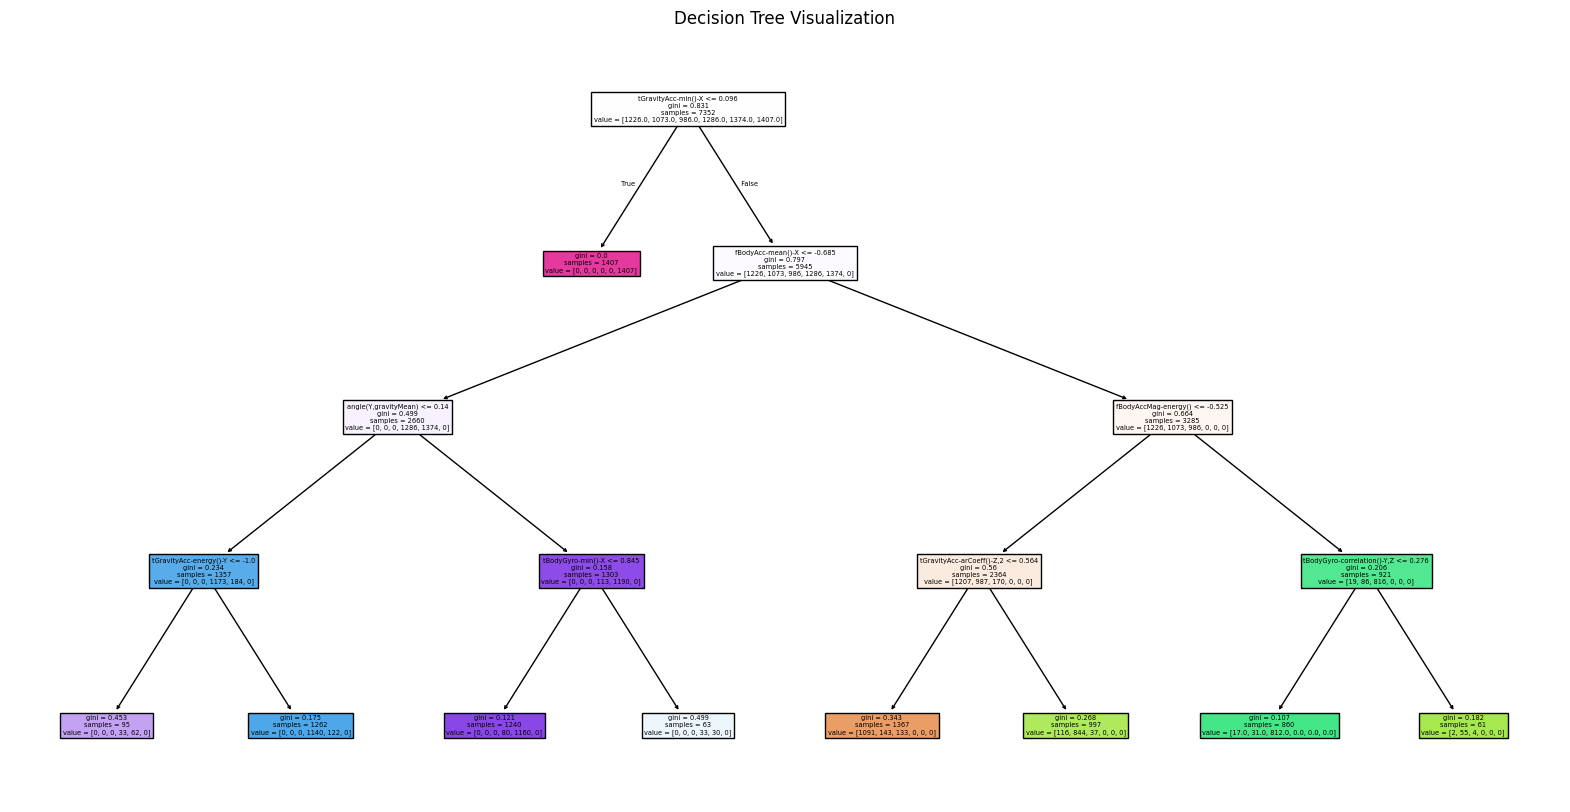

Accuracy: 0.8096
Recall: 0.8096
Precision: 0.8253

Confusion Matrix:

     1    2    3    4    5    6
1  437   48   11    0    0    0
2  129  336    6    0    0    0
3  107   52  261    0    0    0
4    0    0    0  397   94    0
5    0    0    0  114  418    0
6    0    0    0    0    0  537


Tree of Depth : 5


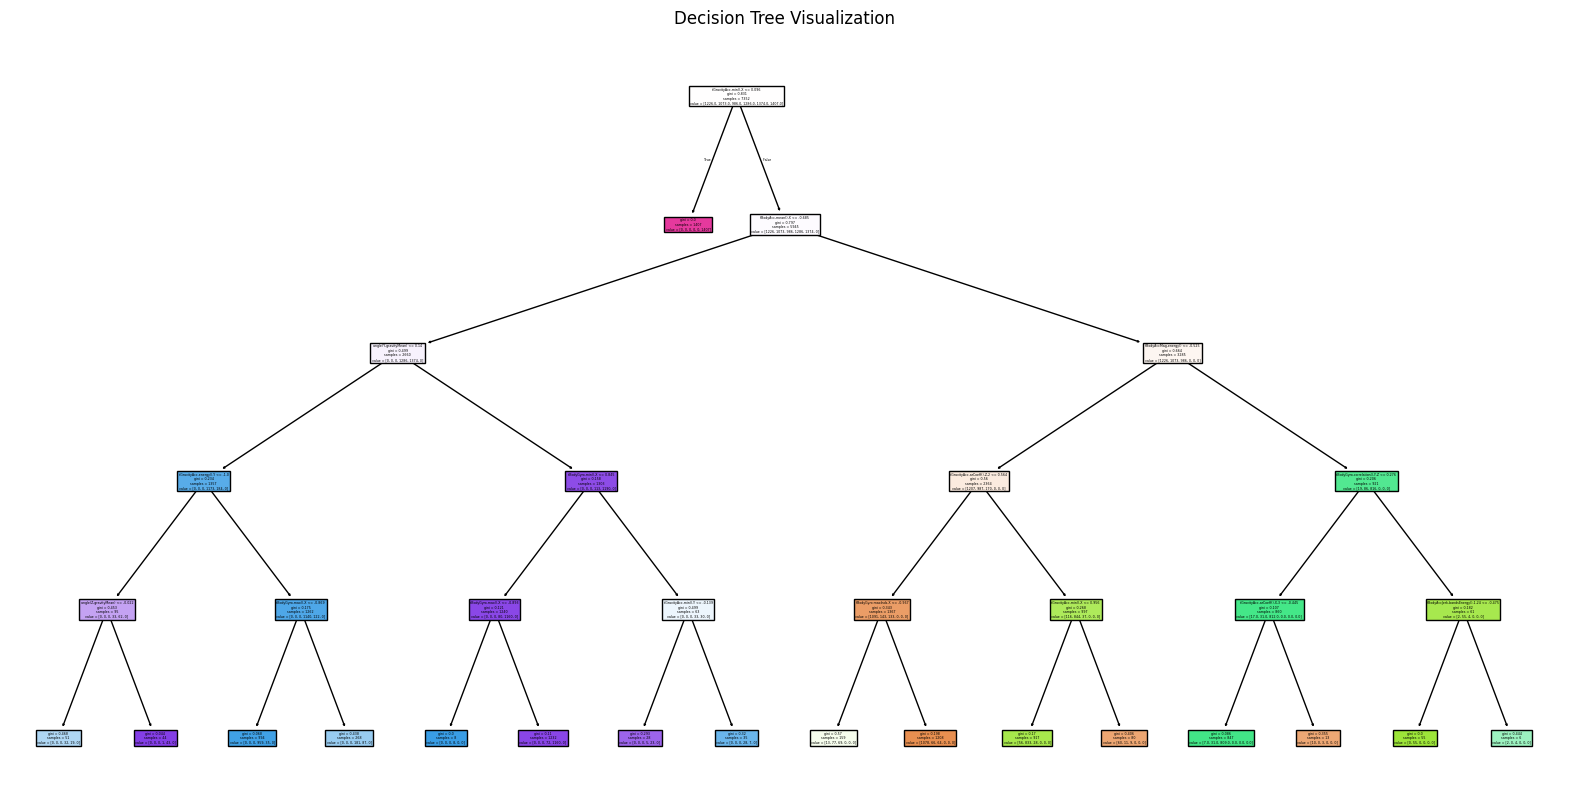

Accuracy: 0.8385
Recall: 0.8385
Precision: 0.8468

Confusion Matrix:

     1    2    3    4    5    6
1  470   16   10    0    0    0
2   86  379    6    0    0    0
3   49  105  266    0    0    0
4    0    0    0  400   91    0
5    0    0    0  113  419    0
6    0    0    0    0    0  537


Tree of Depth : 6


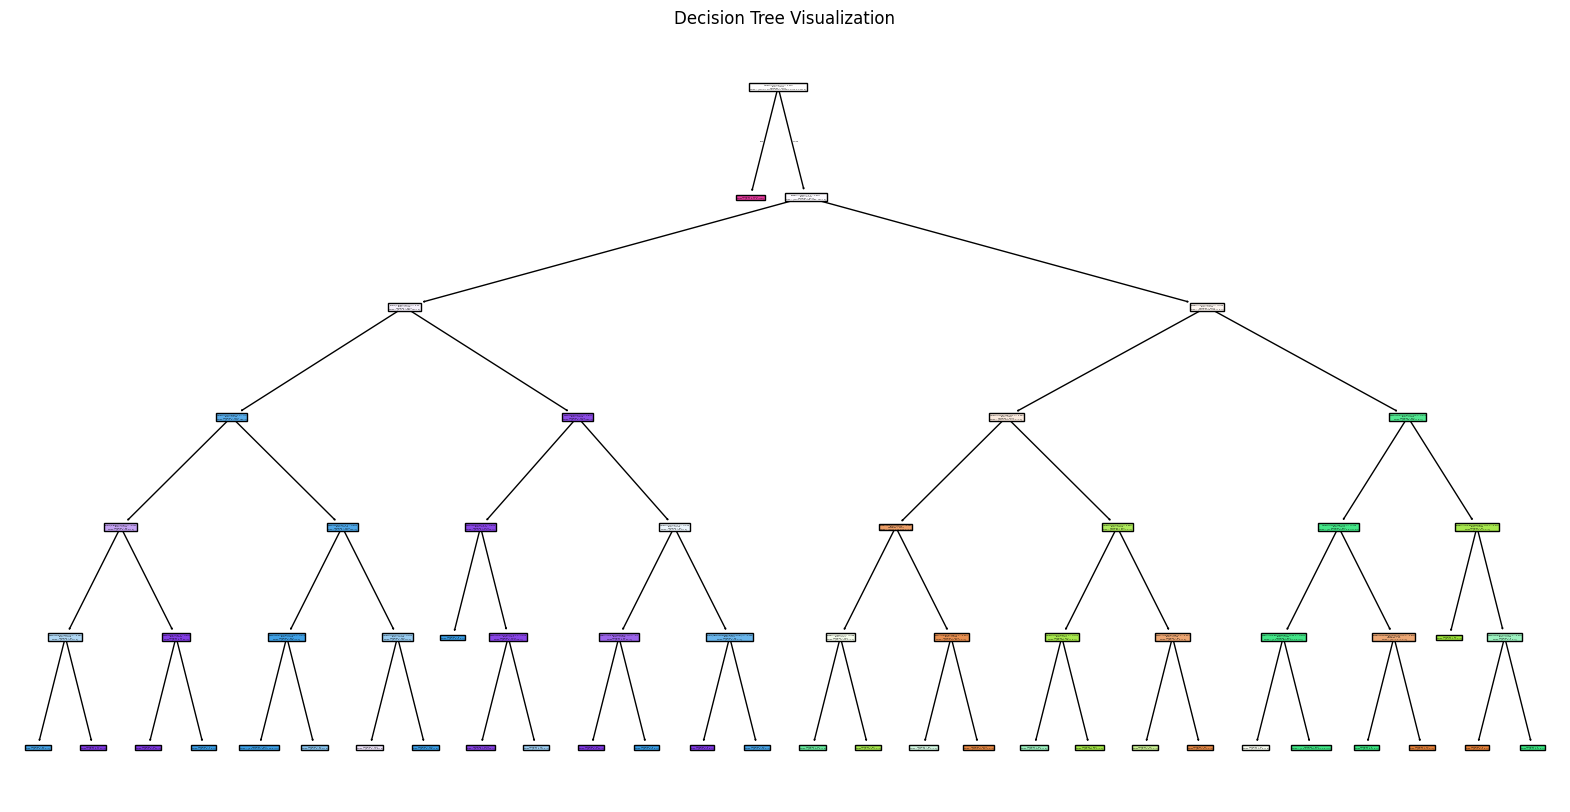

Accuracy: 0.8544
Recall: 0.8544
Precision: 0.8604

Confusion Matrix:

     1    2    3    4    5    6
1  461    5   30    0    0    0
2   43  343   85    0    0    0
3   31   45  344    0    0    0
4    0    0    0  344  147    0
5    0    0    0   43  489    0
6    0    0    0    0    0  537


Tree of Depth : 7


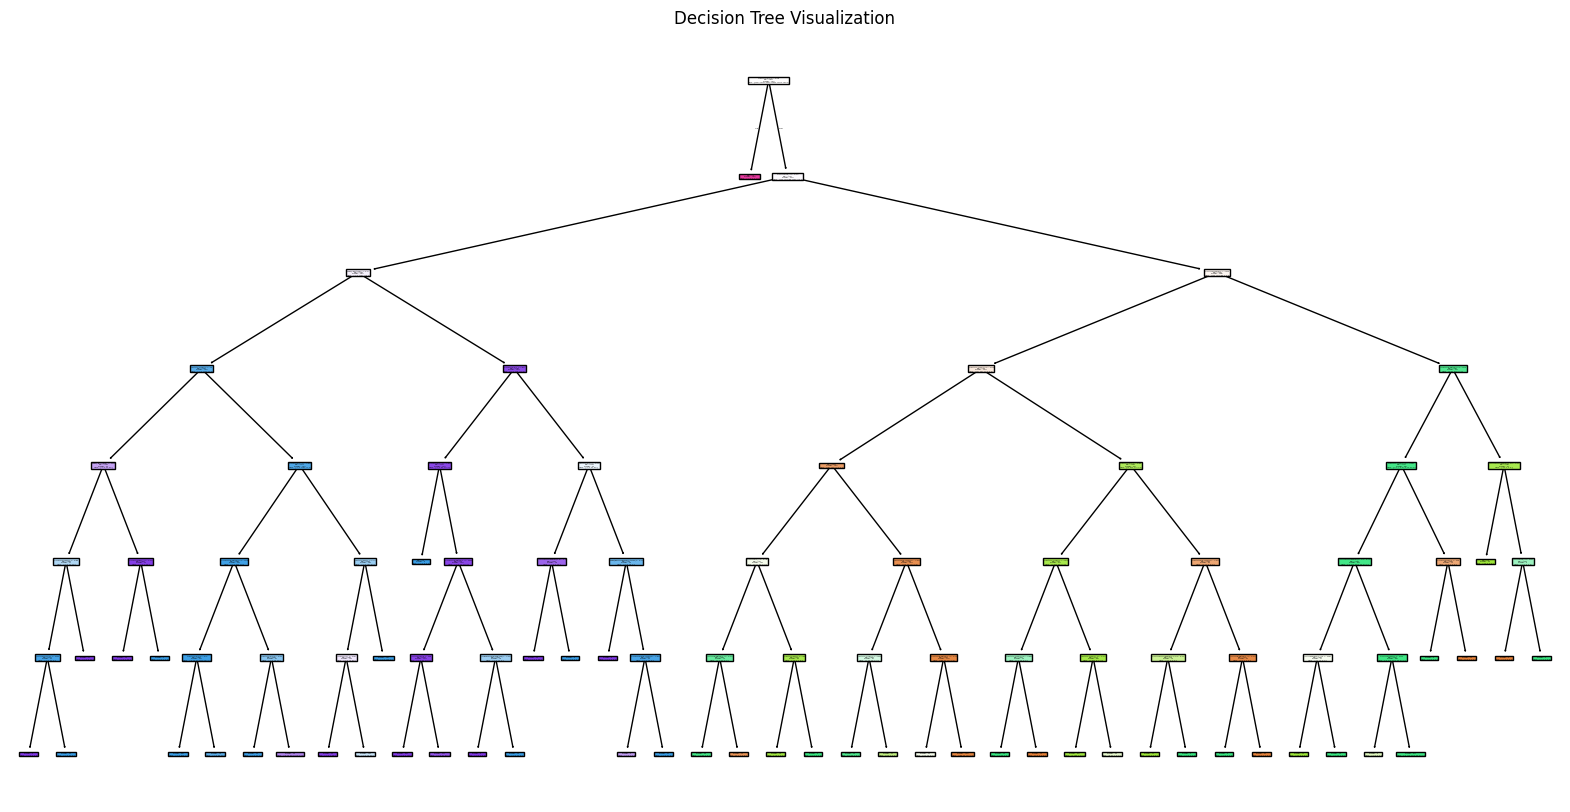

Accuracy: 0.8639
Recall: 0.8639
Precision: 0.8648

Confusion Matrix:

     1    2    3    4    5    6
1  472    8   16    0    0    0
2   78  369   24    0    0    0
3   16   61  343    0    0    0
4    0    0    0  386  105    0
5    0    0    0   93  439    0
6    0    0    0    0    0  537


Tree of Depth : 8


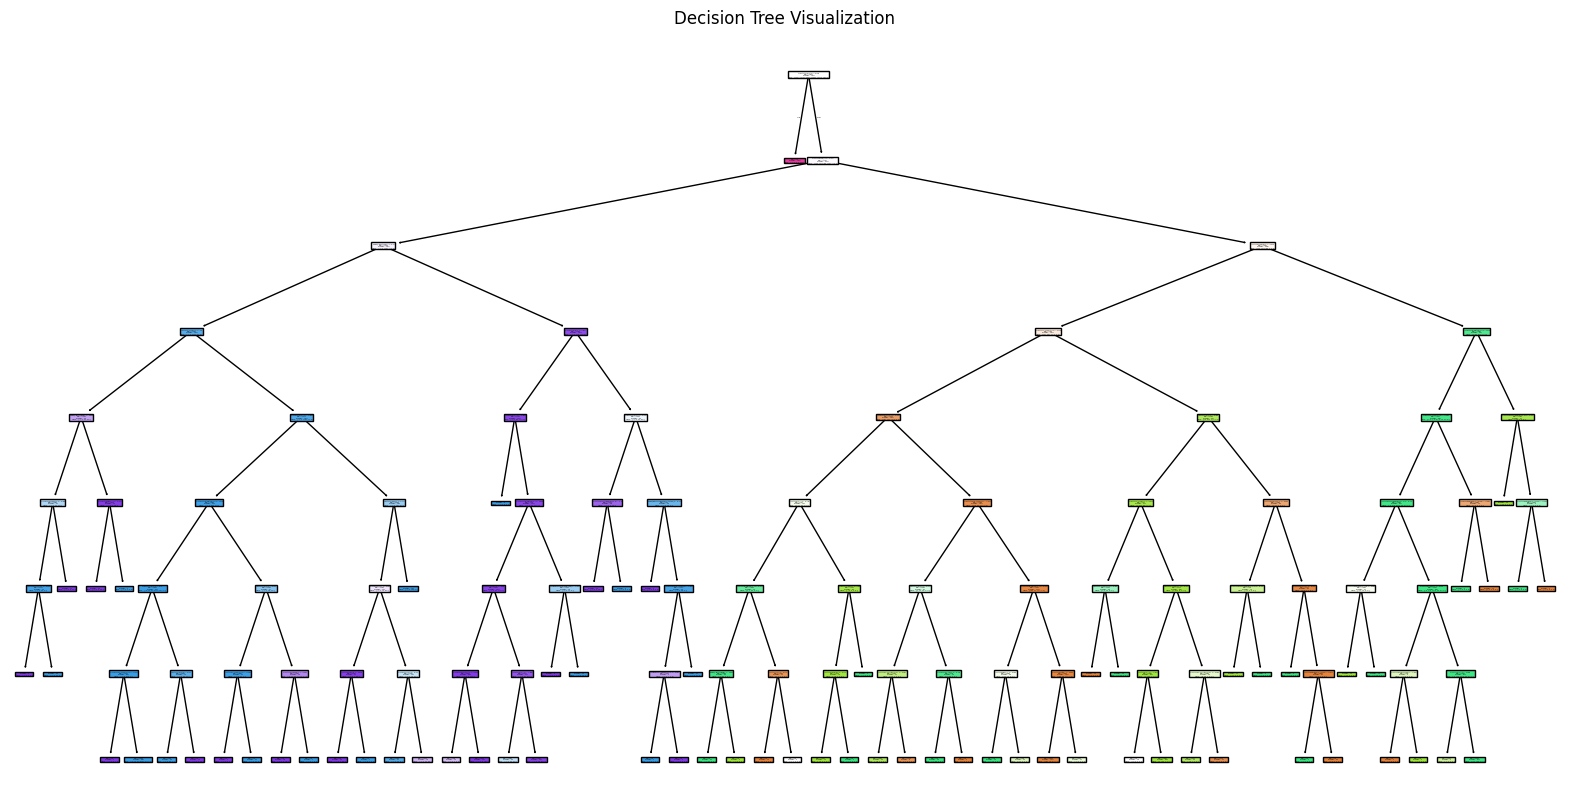

Accuracy: 0.8731
Recall: 0.8731
Precision: 0.8755

Confusion Matrix:

     1    2    3    4    5    6
1  470   11   15    0    0    0
2   76  373   22    0    0    0
3   17   56  347    0    0    0
4    0    0    0  371  120    0
5    0    0    0   57  475    0
6    0    0    0    0    0  537




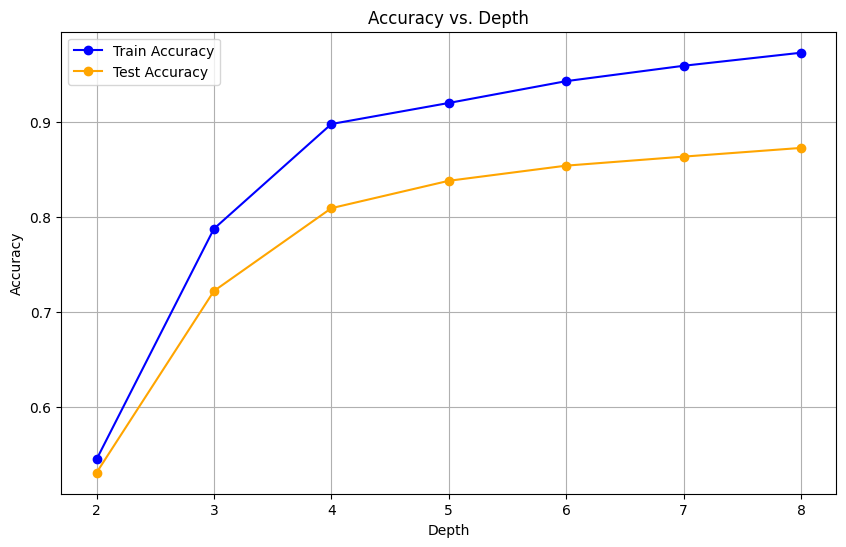

In [17]:
acc_test =[]
acc_train = []
depth = []
for i in range(2,9):
    print("Tree of Depth :",i)
    acc_test_point,acc_train_point = decision_tree_features(depth = i)
    print()
    print()
    acc_test.append(acc_test_point)
    depth.append(i)
    acc_train.append(acc_train_point)

accuracy_dataframe = pd.DataFrame({"Depth":depth,"Train Accuracy":acc_train,"Test Accuracy":acc_test})

bias_variance_plotter(accuracy_dataframe)